In [1]:
import os, pickle
from tqdm import tqdm  # Import tqdm for progress tracking
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import pyemma
import pyemma.coordinates as coor
from joblib import Parallel, delayed


## Load in important functions

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)
    

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

## Prepare the Data and the log (indicating of the data state)

In [5]:
all_omegas = [] # Load in the omega values for all replicas

for state in range(3):  # Adjust the range to include all replicas
    omega_path = f"omega_data/omegas_state{state}.pkl"
    omegas = Data.load(omega_path)
    omegas = omegas.array_list
    all_omegas.append(np.array(omegas))
    
all_omegas = np.array(all_omegas)  # (nreps, nsnaps, nresidues)
print('all_omegas.shape', all_omegas.shape)

# Arrange each snapshot by replica (not temp)
replica_indices = np.loadtxt('state_new.dat')
print("replica_indices.shape", replica_indices.shape)
#print(replica_indices)

# Convert the data into cistrans 
all_cistrans = omega2cistrans(all_omegas)
print('all_omegas.shape', all_omegas.shape)

start = 0
nsnaps = 212509
nreps = 3
nres = 3

all_omegas_by_replica_and_state = np.zeros((nreps, nsnaps, nres + 1))


for i in range(nsnaps):
    Ind = np.argsort(replica_indices[i, :]) # find the index of replica
    all_omegas_by_replica_and_state[:, i, :-1] = all_cistrans[Ind, i, :]
    all_omegas_by_replica_and_state[:, i, -1] = Ind  # State is found by indexing
    #print(all_omegas_by_replica_and_state)

print(replica_indices[:3, :])
all_omegas_by_replica_and_state[:, :3, :]

all_omegas.shape (3, 212509, 3)
replica_indices.shape (212509, 3)
all_omegas.shape (3, 212509, 3)
[[0. 1. 2.]
 [0. 1. 2.]
 [1. 0. 2.]]


array([[[1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 2.],
        [0., 0., 0., 2.],
        [0., 0., 0., 2.]]])

In [6]:
all_omegas_by_replica_and_state_res_0 = all_omegas_by_replica_and_state[:, :, [0, 3]]
all_omegas_by_replica_and_state_res_1 = all_omegas_by_replica_and_state[:, :, [1, 3]]
all_omegas_by_replica_and_state_res_2 = all_omegas_by_replica_and_state[:, :, [2, 3]]


all_omegas_by_replica_and_state_res_0[:, :3, :]

array([[[1., 0.],
        [1., 0.],
        [1., 1.]],

       [[0., 1.],
        [0., 1.],
        [0., 0.]],

       [[0., 2.],
        [0., 2.],
        [0., 2.]]])

## Functions 

In [7]:
import numpy as np

def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 2) array of states into (N, M) indices in [0..5].

    Assumes:
      - The first entries in the state are binary bits (0 or 1).
      - The last entry is an integer in [0..2].
      - If any of the two entries is NaN, the output is NaN for that row.

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 2).

    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M). Valid entries are in the range [0..5].
    """
    # Convert to numpy array (float allows NaN)
    all_state_array = np.array(all_state, dtype=float)

    # Validate shape
    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 2:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 2).")

    # Mask for NaNs
    nan_mask = np.isnan(all_state_array).any(axis=-1)

    # Prepare output
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    # Compute indices for valid entries
    valid_mask = ~nan_mask
    weights = np.array([3, 1], dtype=float)
    valid_data = all_state_array[valid_mask]
    results = valid_data @ weights

    indexed_states[valid_mask] = results

    return indexed_states


In [8]:
import numpy as np

def index_to_state(index):
    """
    Converts an index (0..5) back into a (2,) array where:
      - The first entry is a bit (0 or 1),
      - The second entry is an integer in [0..2].

    Inverse of:
        index = 3 * a + x
    """
    if not (0 <= index < 6):
        raise ValueError(f"Index out of range: {index}. Expected 0..5.")

    a = index // 3
    x = index % 3

    return np.array([a, x], dtype=int)


In [9]:
def compute_transition_matrix(subset, num_states, lagtime, pseudocount=0.25):
    """Compute transition matrix for a given subset of trajectories."""
    
    C = np.zeros((num_states, num_states))  # Initialize count matrix

    for traj in subset:
        for t in range(len(traj) - lagtime):
            from_state = traj[t]
            to_state = traj[t + lagtime]

            # Skip NaN transitions
            if np.isnan(from_state) or np.isnan(to_state):
                continue

            # Convert states to integers for indexing
            from_state = int(from_state)
            to_state = int(to_state)

            # Count transitions
            C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities
    row_sums = C.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    T = C / row_sums        
    
    return T

In [10]:
def get_transition_matrices(n_trajs, num_states, lagtime, cluster_size=10, pseudocount=0.25, n_jobs=-1):
    """
    Compute transition matrices for subsets of trajectories in parallel.
    """

    num_trajs = n_trajs.shape[0]  # Number of trajectories
    
    # Shuffle indices
    indices = np.arange(num_trajs)
    np.random.shuffle(indices)

    # Split into clusters
    clusters = [indices[i:i + cluster_size] for i in range(0, num_trajs, cluster_size)]

    # Merge last small cluster with the second-last if needed
    if len(clusters) > 1 and len(clusters[-1]) < cluster_size:
        clusters[-2] = np.concatenate([clusters[-2], clusters[-1]])  
        clusters.pop()

    # Parallel computation of transition matrices
    def process_cluster(cluster):
        subset = n_trajs[cluster]
        # Call your existing compute_transition_matrix
        T = compute_transition_matrix(subset, num_states, lagtime, pseudocount)
        return T

    # Use joblib's Parallel for parallelism. 
    # `delayed(process_cluster)(c)` calls `process_cluster(c)` lazily.
    # `n_jobs=-1` uses all available CPUs unless specified otherwise.
    transition_matrices = Parallel(n_jobs=n_jobs)(
        delayed(process_cluster)(cluster) 
        for cluster in tqdm(clusters, desc="Computing transition matrices", unit="cluster")
    )

    return transition_matrices


In [11]:
def compute_stationary_distribution(T, lagtime):
    """Compute the stationary distribution of a transition matrix T.
    
    INPUT:
    T - Transition matrix where T_ij is the probability of transitioning i -> j.
    
    RETURN:
    pi - The stationary distribution (1D NumPy array).
    t2 - The implied timescale (in units of steps).
    """
    try:
        # Compute the implied timescale
        evals = np.linalg.eigvals(T.transpose() )  # will be something like [0.99754545 1.        ]
        evals_sorted = np.sort(evals)      # ascending order
        mu2 = evals_sorted[-2]            # second-largest eigenvalue
        #print('mu2', mu2, 'evals', evals, 'evals_sorted', evals_sorted, 'T', T)
        
        t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
        #print('evals_sorted', evals_sorted, 'mu2', mu2, 't2', t2)

        # Compute the stationary state distribution 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)  # (T' - I)
        A = np.vstack([A, np.ones(n_states)])  # Append normalization row
        b = np.zeros(n_states + 1)
        b[-1] = 1  # Ensure probability sums to 1
        
        # Solve for stationary distribution using least squares
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
        # Ensure non-negative values and normalize
        pi = np.maximum(pi, 0)  # Prevent small negative values due to numerical error
        pi /= np.sum(pi)  # Normalize to sum to 1

    except Exception as e:
        print(f"Error computing stationary distribution: {e}")
        t2 = np.nan
        pi = None

    return pi, t2

## Calculating the stationary population and implied timescale

In [12]:

traj_all_index = np.stack([
    state_to_index_vectorized(all_omegas_by_replica_and_state_res_0),
    state_to_index_vectorized(all_omegas_by_replica_and_state_res_1),
    state_to_index_vectorized(all_omegas_by_replica_and_state_res_2)
], axis=0)

print('traj_all.shape', traj_all_index.shape)
print(all_omegas_by_replica_and_state_res_0[1, :, :])
print(traj_all_index[1, :, :])

traj_all.shape (3, 3, 212509)
[[0. 1.]
 [0. 1.]
 [0. 0.]
 ...
 [1. 2.]
 [1. 2.]
 [1. 2.]]
[[3. 3. 4. ... 3. 3. 4.]
 [1. 1. 0. ... 5. 2. 2.]
 [2. 2. 2. ... 1. 1. 0.]]


In [13]:
def process_trajectory(n_trajs, lagtime, num_states, cluster_size):

    # Calculate the transition matrix 
    transition_matrices = get_transition_matrices(n_trajs, num_states, lagtime, cluster_size, pseudocount=0.25, n_jobs=-1)
    transition_matrices = np.array(transition_matrices)
    #print('transition_matrices.shape', transition_matrices.shape)

    # Calculate the stationary population 
    pi_all = []
    t2_all = []

    
    for T in transition_matrices:
        pi, t2 = compute_stationary_distribution(T, lagtime)
        pi_all.append(pi)
        t2_all.append(t2)

    pi_all = np.array(pi_all)
    t2_all = np.array(t2_all)


    t2_mean = np.exp(np.mean([np.log(t2) for t2 in t2_all]))
    t2_std = np.exp(np.sqrt(np.var([np.log(t2) for t2 in t2_all])))
    pi_means = np.mean(pi_all, axis=0)  # Mean across trajectories
    pi_std = np.std(pi_all, axis=0)  # Standard deviation   
    
    return pi_means, pi_std, t2_mean, t2_std

#print(pi_all)

In [14]:
num_states = 6
#lagtimes = [1]
lagtimes = [5, 10, 25, 50] + list(range(100, 212509, 500))
#lagtimes = [5, 10, 25, 50]
dt_in_ns = 0.004  
cluster_size = 1

# Final results (across all trajs)
pi_all_means = []
pi_all_uppers = []
pi_all_lowers = []
pi_all_stds = []

t2_all_means = []
t2_all_uppers = []
t2_all_lowers = []
t2_all_stds = []

for n_trajs in tqdm(traj_all_index, desc="Processing trajectories"):

    # Temporary results for this trajectory
    pi_means_list = []
    pi_uppers_list = []
    pi_lowers_list = []
    pi_stds_list = []

    t2_means_list = []
    t2_uppers_list = []
    t2_lowers_list = []
    t2_stds_list = []

    for lagtime in tqdm(lagtimes, desc="Processing Lag Times", unit="lag"):

        pi_means, pi_std, t2_mean, t2_std = process_trajectory(n_trajs, lagtime, num_states, cluster_size)

        # Confidence bounds
        pi_uppers = pi_means + pi_std
        pi_lowers = pi_means - pi_std
        t2_uppers = t2_mean + t2_std
        t2_lowers = t2_mean - t2_std

        # Append to per-traj lists
        pi_means_list.append(pi_means)
        pi_uppers_list.append(pi_uppers)
        pi_lowers_list.append(pi_lowers)
        pi_stds_list.append(pi_std)

        t2_means_list.append(t2_mean)
        t2_uppers_list.append(t2_uppers)
        t2_lowers_list.append(t2_lowers)
        t2_stds_list.append(t2_std)

    # Convert per-traj results to arrays and store
    pi_all_means.append(np.array(pi_means_list))
    pi_all_uppers.append(np.array(pi_uppers_list))
    pi_all_lowers.append(np.array(pi_lowers_list))
    pi_all_stds.append(np.array(pi_stds_list))

    t2_all_means.append(np.array(t2_means_list))
    t2_all_uppers.append(np.array(t2_uppers_list))
    t2_all_lowers.append(np.array(t2_lowers_list))
    t2_all_stds.append(np.array(t2_stds_list))

# Final shape: (n_trajs, n_lagtimes, num_states)
pi_all_means = np.array(pi_all_means)
pi_all_uppers = np.array(pi_all_uppers)
pi_all_lowers = np.array(pi_all_lowers)
pi_all_stds = np.array(pi_all_stds)

t2_all_means = np.array(t2_all_means)
t2_all_uppers = np.array(t2_all_uppers)
t2_all_lowers = np.array(t2_all_lowers)
t2_all_stds = np.array(t2_all_stds)

lagtimes_ns = np.array(lagtimes) * dt_in_ns

# Print final shapes
print("pi_all_means.shape:", pi_all_means.shape)  # (n_trajs, n_lagtimes, num_states)
print("pi_all_stds.shape:", pi_all_stds.shape)    
print("t2_all_means.shape:", t2_all_means.shape)
print("t2_all_stds.shape:", t2_all_stds.shape)

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 100.00cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 1081.47cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 888.94cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 964.95cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 1405.91cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 1122.27cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 1466.88cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 1884.23cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 848.88cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 1264.74cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 1196.66cluster/s]

Computing transition matrices: 100%|██████████| 3/3 [00:00<00:00, 104

pi_all_means.shape: (3, 429, 6)
pi_all_stds.shape: (3, 429, 6)
t2_all_means.shape: (3, 429)
t2_all_stds.shape: (3, 429)


In [15]:
# Create an instance of Data with your arrays
data_instance = Data([pi_all_means, pi_all_uppers, pi_all_lowers, pi_all_stds, 
                      t2_all_means, t2_all_uppers, t2_all_lowers, t2_all_stds, lagtimes_ns])

# Save to a file
os.makedirs('autocoorel_data', exist_ok=True)
data_instance.save("autocoorel_data/stationary_distributions_res.pkl")

## Load the data and plot the fig of stationary population and implied timescale 

In [16]:
import numpy as np

def index_to_state(index):
    """
    Converts an index (0..5) back into a (2,) array where:
      - The first entry is a bit (0 or 1),
      - The second entry is an integer in [0..2].

    Inverse of:
        index = 3 * a + x
    """
    if not (0 <= index < 6):
        raise ValueError(f"Index out of range: {index}. Expected 0..5.")

    a = index // 3
    x = index % 3

    return np.array([a, x], dtype=int)


In [17]:
omega_loaded = Data.load("autocoorel_data/stationary_distributions_res.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_uppers = omega_loaded[1]
pi_all_lowers = omega_loaded[2]
pi_all_stds = omega_loaded[3]
t2_all_means = omega_loaded[4]
t2_all_uppers = omega_loaded[5]
t2_all_lowers = omega_loaded[6]
t2_all_stds = omega_loaded[7]
lagtimes_ns = omega_loaded[8]

pi_all_means


array([[[0.09279664, 0.09838962, 0.10409257, 0.24053995, 0.23494378,
         0.22923743],
        [0.09277102, 0.09838212, 0.10408973, 0.24056751, 0.23495143,
         0.2292382 ],
        [0.09280435, 0.09839898, 0.10408878, 0.24053326, 0.23493495,
         0.22923968],
        ...,
        [0.00976996, 0.07435237, 0.13269755, 0.35000641, 0.22869727,
         0.20447643],
        [0.01869455, 0.06521558, 0.12305448, 0.27865104, 0.30984735,
         0.204537  ],
        [0.02771695, 0.05971792, 0.12308193, 0.27577821, 0.31279072,
         0.20091425]],

       [[0.18476751, 0.18396004, 0.16858386, 0.14856292, 0.14937415,
         0.16475152],
        [0.18475161, 0.18395646, 0.16857765, 0.14857739, 0.14937744,
         0.16475945],
        [0.18478565, 0.18395851, 0.16856576, 0.14854246, 0.14937565,
         0.16477197],
        ...,
        [0.25058547, 0.18216988, 0.10235205, 0.32513784, 0.06086216,
         0.0788926 ],
        [0.17756359, 0.17037574, 0.22284628, 0.13305145, 0.160

### Plot the Population

In [18]:
state_num = 3
cis_trans_pi_means = []  # To store each (3, 604, 2)
cis_trans_pi_stds = []

for state in range(state_num):
    
    cis_state = state + 0
    trans_state = state + state_num

    pi_means_state = pi_all_means[:, :, [cis_state, trans_state]]
    pi_stds_state = pi_all_stds[:, :, [cis_state, trans_state]]
    
    # Compute row sums
    row_sums = pi_means_state.sum(axis=2, keepdims=True)
    pi_means_state /= row_sums # Renormalize the mean 
    pi_stds_state /= row_sums # Renormalize the standard deviation

    # Print shapes to confirm correctness
    print(f"pi_means_state shape: {pi_means_state.shape}")  # Expected: (3, 604, 2)
    print(f"pi_stds_state shape: {pi_stds_state.shape}")  # Expected: (3, 604, 2)

    # Store each normalized pair
    cis_trans_pi_means.append(pi_means_state)
    cis_trans_pi_stds.append(pi_stds_state)

# Stack results into shape: (6, 3, 604, 2)
cis_trans_pi_means = np.stack(np.array(cis_trans_pi_means), axis=0)
cis_trans_pi_stds = np.stack(np.array(cis_trans_pi_stds), axis=0)

print("cis_trans_pi_means shape:", cis_trans_pi_means.shape)
print("cis_trans_pi_stds shape:", cis_trans_pi_stds.shape)


pi_means_state shape: (3, 429, 2)
pi_stds_state shape: (3, 429, 2)
pi_means_state shape: (3, 429, 2)
pi_stds_state shape: (3, 429, 2)
pi_means_state shape: (3, 429, 2)
pi_stds_state shape: (3, 429, 2)
cis_trans_pi_means shape: (3, 3, 429, 2)
cis_trans_pi_stds shape: (3, 3, 429, 2)


Traj 0, State 0: 12.40 ns : 0.721
Traj 0, State 1: 12.40 ns : 0.704
Traj 0, State 2: 12.40 ns : 0.687


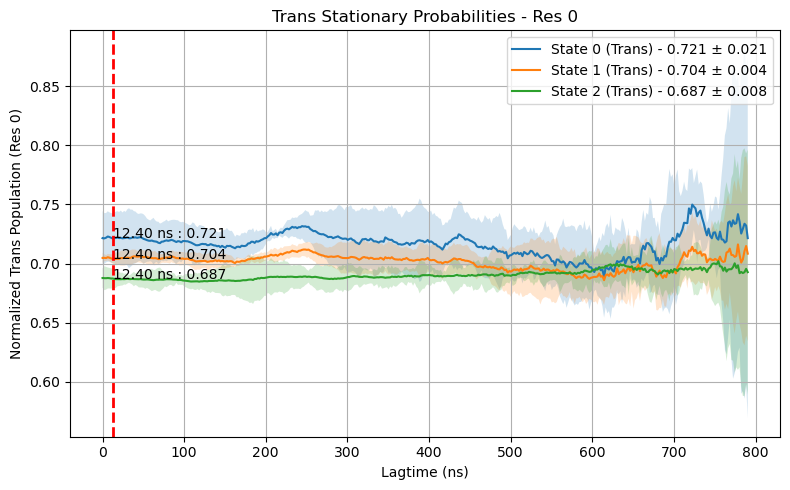

Traj 1, State 0: 12.40 ns : 0.444
Traj 1, State 1: 12.40 ns : 0.448
Traj 1, State 2: 12.40 ns : 0.494


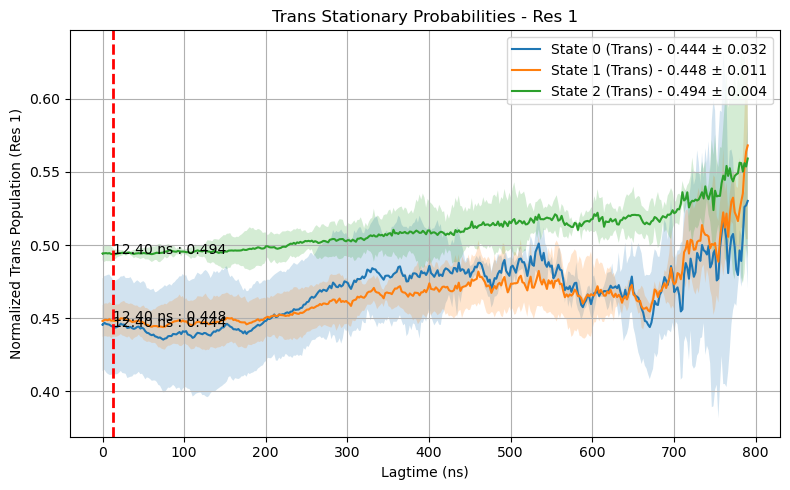

Traj 2, State 0: 12.40 ns : 0.593
Traj 2, State 1: 12.40 ns : 0.596
Traj 2, State 2: 12.40 ns : 0.593


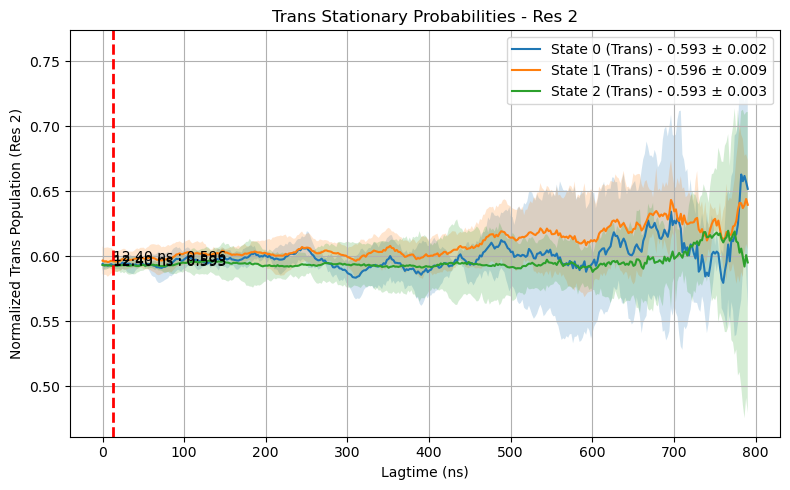

In [19]:
point_to_plot = 400
lagtime_plot = 10  # Index of lagtime to annotate
state_num = 3

for res_index in range(3):
    plt.figure(figsize=(8, 5))

    for state_index in range(state_num):
        res = cis_trans_pi_means[state_index, res_index]   # shape (604, 2)
        std = cis_trans_pi_stds[state_index, res_index]    # shape (604, 2)

        # Plot trans population
        plt.plot(
            lagtimes_ns[:point_to_plot], 
            res[:point_to_plot, 1], 
            label=f"State {state_index} (Trans) - {res[lagtime_plot, 1]:.3f} ± {std[lagtime_plot, 1]:.3f}"
        )

        # Fill between ± std
        plt.fill_between(
            lagtimes_ns[:point_to_plot],
            res[:point_to_plot, 1] + std[:point_to_plot, 1],
            res[:point_to_plot, 1] - std[:point_to_plot, 1],
            alpha=0.2
        )

        # Annotate a specific lagtime point
        first_x = lagtimes_ns[lagtime_plot]
        first_y = res[lagtime_plot, 1]
        plt.text(first_x, first_y, f"{first_x:.2f} ns : {first_y:.3f}", fontsize=10)
        print(f"Traj {res_index}, State {state_index}: {first_x:.2f} ns : {first_y:.3f}")

    plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)

    plt.title(f"Trans Stationary Probabilities - Res {res_index}")
    plt.xlabel("Lagtime (ns)")
    plt.ylabel(f"Normalized Trans Population (Res {res_index})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Traj 0, State 0: 196.40 ns : 0.720
Traj 0, State 1: 196.40 ns : 0.705
Traj 0, State 2: 196.40 ns : 0.688
Traj 1, State 0: 196.40 ns : 0.447
Traj 1, State 1: 196.40 ns : 0.449
Traj 1, State 2: 196.40 ns : 0.498
Traj 2, State 0: 196.40 ns : 0.600
Traj 2, State 1: 196.40 ns : 0.602
Traj 2, State 2: 196.40 ns : 0.592


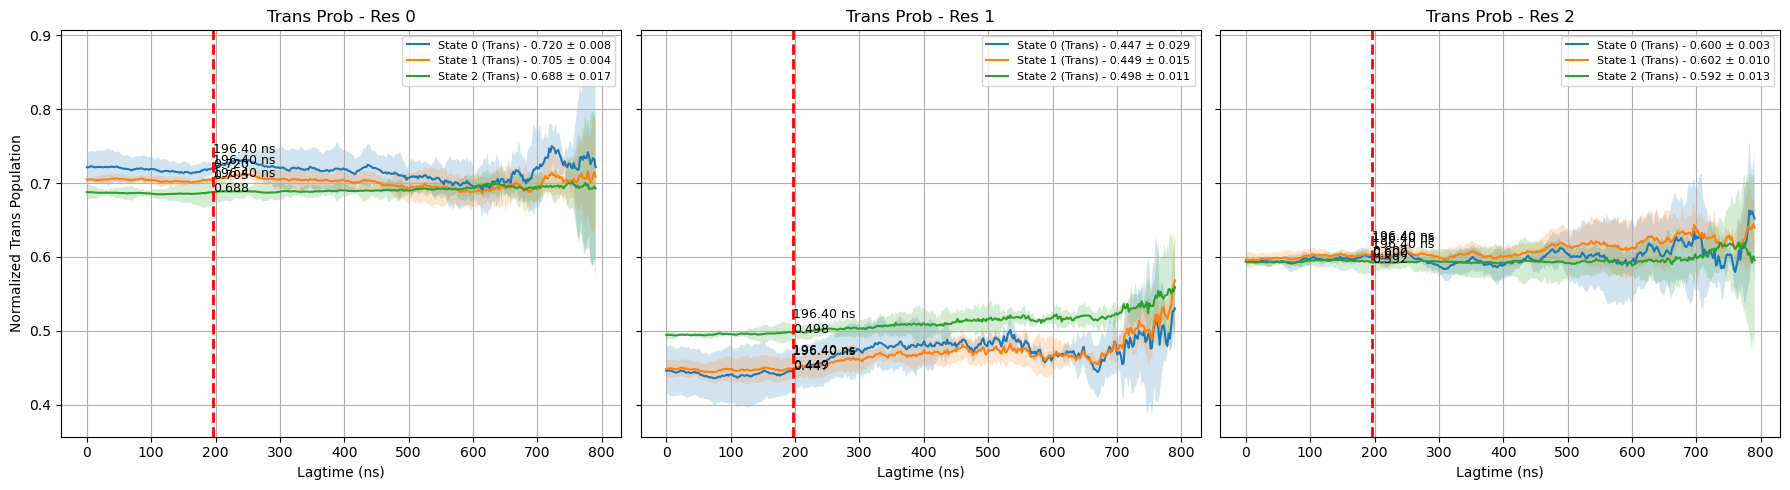

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Example dummy data — replace with your real data
point_to_plot = 400
lagtime_plot = 102  # Index of lagtime to annotate
state_num = 3
residue_num = 3

# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for res_index in range(residue_num):
    ax = axs[res_index]

    for state_index in range(state_num):
        res = cis_trans_pi_means[state_index, res_index]
        std = cis_trans_pi_stds[state_index, res_index]

        ax.plot(
            lagtimes_ns[:point_to_plot],
            res[:point_to_plot, 1],
            label=f"State {state_index} (Trans) - {res[lagtime_plot, 1]:.3f} ± {std[lagtime_plot, 1]:.3f}"
        )

        ax.fill_between(
            lagtimes_ns[:point_to_plot],
            res[:point_to_plot, 1] + std[:point_to_plot, 1],
            res[:point_to_plot, 1] - std[:point_to_plot, 1],
            alpha=0.2
        )

        # Annotate specific lagtime point
        first_x = lagtimes_ns[lagtime_plot]
        first_y = res[lagtime_plot, 1]
        ax.text(first_x, first_y, f"{first_x:.2f} ns\n{first_y:.3f}", fontsize=9)
        print(f"Traj {res_index}, State {state_index}: {first_x:.2f} ns : {first_y:.3f}")

    ax.axvline(x=first_x, color='r', linestyle='--', linewidth=2)
    ax.set_title(f"Trans Prob - Res {res_index}")
    ax.set_xlabel("Lagtime (ns)")
    ax.grid(True)
    ax.legend(fontsize=8)

axs[0].set_ylabel("Normalized Trans Population")
plt.tight_layout()
plt.show()


In [21]:
## Save the data into a csv

point_to_plot = 4
lagtime_plot = 1  # index of lagtime to extract at 101 ns
selected_ns = lagtimes_ns[lagtime_plot]  # for saving
state_num = 3

# Collect into a list of dicts for easy DataFrame creation
data_rows = []

for res_index in range(3):  # 3 trajectories
    for state_index in range(state_num):  # 6 states
        res = cis_trans_pi_means[state_index, res_index]  # shape (604, 2)
        std = cis_trans_pi_stds[state_index, res_index]

        mean_val = res[lagtime_plot, 1]  # Trans
        std_val = std[lagtime_plot, 1]

        data_rows.append({
            'res': res_index,
            'state': state_index,
            'lagtime_index': lagtime_plot,
            'lagtime_ns': selected_ns,
            'mean': mean_val,
            'std': std_val
        })

# Create a DataFrame
df = pd.DataFrame(data_rows)

# Save to CSV (or change to .tsv)
df.to_csv("autocoorel_data/trans_population_at_lagtime.csv", index=False)

print("Saved data to autocoorel_data/trans_population_at_lagtime.csv")


Saved data to autocoorel_data/trans_population_at_lagtime.csv


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_52425/1478484340.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 10000)


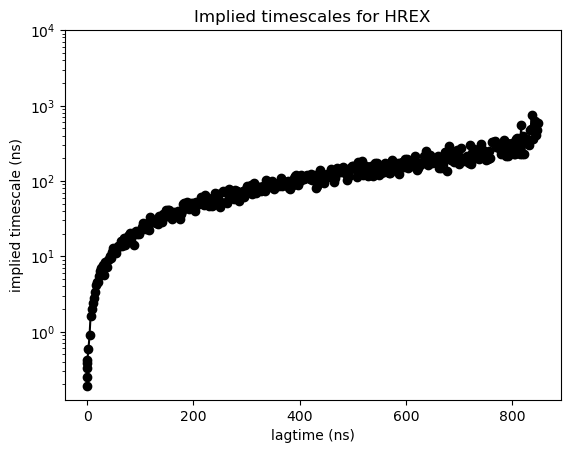

/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_52425/1478484340.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 10000)


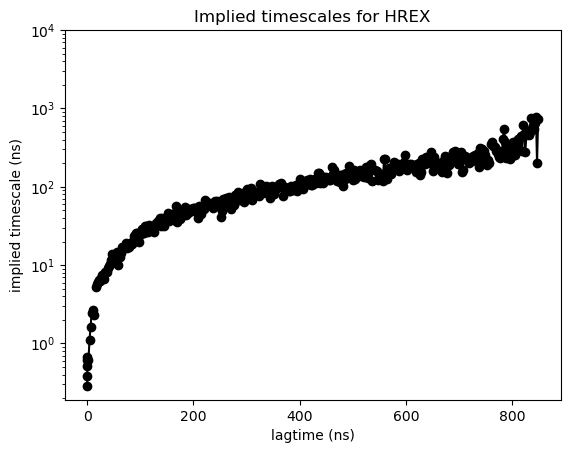

/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_52425/1478484340.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 10000)


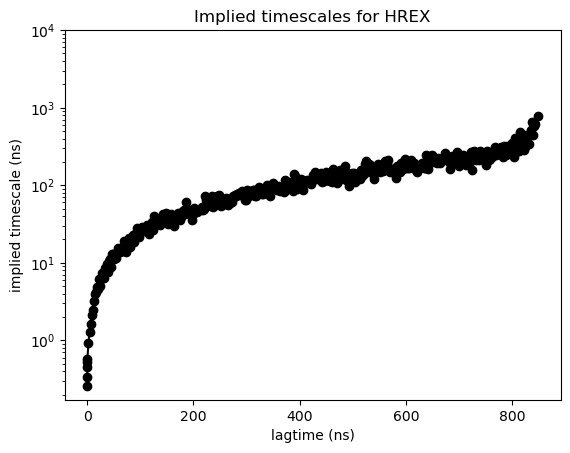

In [22]:
dt_in_ns = 0.004

plt.figure()

for i in range(3):
    plt.plot(lagtimes_ns, t2_all_means[i]*dt_in_ns, 'ko-')
    #plt.fill_between(lagtimes_ns, t2_all_uppers[i]*dt_in_ns, t2_all_lowers*dt_in_ns, alpha=0.2)
    plt.xlabel('lagtime (ns)')
    plt.ylabel('implied timescale (ns)')
    
    plt.yscale('log')
    plt.ylim(0, 10000)
    plt.title(f'Implied timescales for HREX')
    plt.show()
